## 11.2 Single level approaches
Traditionally, forecasts of hierarchical or grouped time series involved selecting one level of aggregation and generating forecasts for that level. These are then either aggregated for higher levels, or disaggregated for lower levels, to obtain a set of coherent forecasts for the rest of the structure.

### The bottom-up approach
A simple method for generating coherent forecasts is the “bottom-up” approach. This approach involves first generating forecasts for each series at the bottom level, and then summing these to produce forecasts for all the series in the structure.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from utils import *

In [18]:
df = pd.read_csv('../data/tsibble/tourism.csv')

In [19]:
df_agg_states = (
    df.assign(date=lambda df: pd.to_datetime(df.Quarter.str.replace(" ", "")))
    .groupby(["State", "date"])
    .agg({"Trips": "sum"})
    .reset_index()
    .replace(
        {
            "New South Wales": "NSW",
            "Northern Territory": "NT",
            "Queensland": "QLD",
            "South Australia": "SA",
            "Tasmania": "TAS",
            "Victoria": "VIC",
            "Western Australia": "WA",
        }
    )
)

In [6]:
forecasts = {}

In [28]:
for state, group in df_agg_states.groupby('State'):
    group = group.set_index('date').pipe(set_freq)
    model = sm.tsa.ETSModel(group['Trips'], error='add', trend='add', seasonal='add', seasonal_periods=12)
    fit = model.fit(disp=0)
    forecast = fit.get_prediction(start=len(group), end=len(group)+12-1)
    forecasts[state] = {'forecast': forecast, 'orig': group}

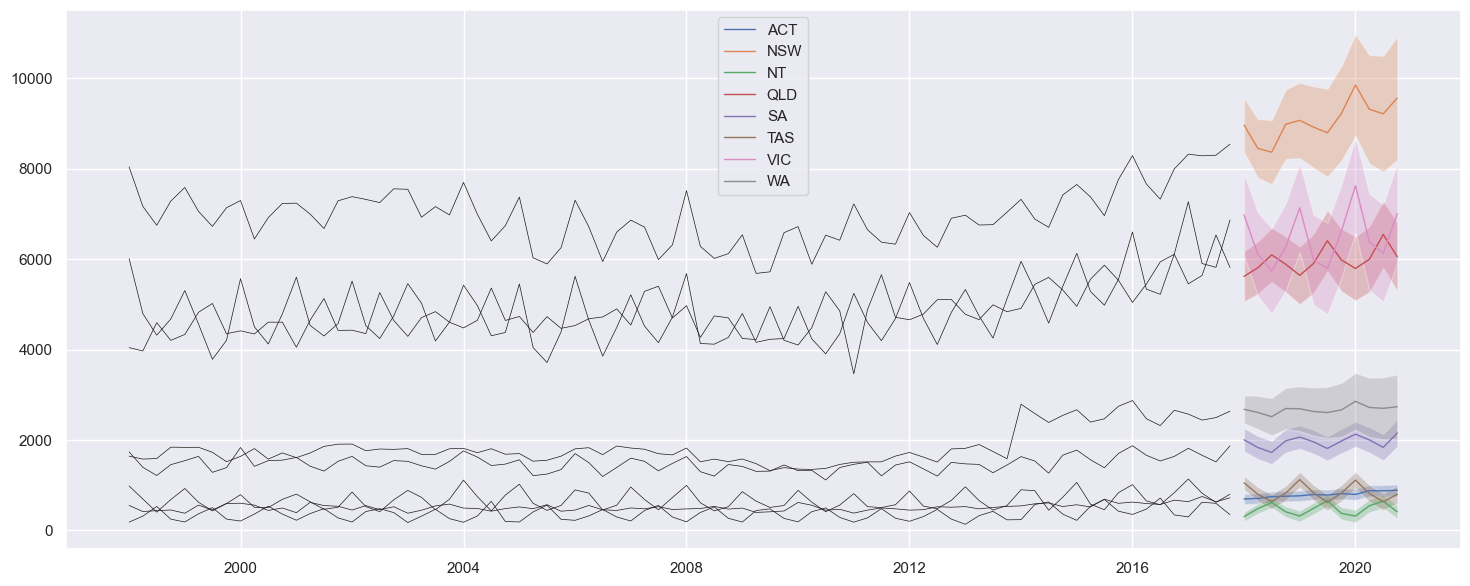

In [39]:
plt.figure()
for state, forecast in forecasts.items():
    forecast_values = forecast['forecast'].predicted_mean
    conf_int = forecast['forecast'].pred_int(alpha=0.05)
    plt.plot(forecast['orig']['Trips'], 'k', linewidth=0.5)
    plt.plot(forecast_values.index, forecast_values, label=f'{state}')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.3)
plt.legend();